In [81]:
import pandas as pd
import plotly.express as px

from tqdm.notebook import trange, tqdm
from pandas_profiling import ProfileReport


In [296]:
df = pd.read_csv('../data/sample_interview_dataset.csv')
df['Failed'] = df['Failure Type'].apply(lambda x: False if x == 'No Failure' else True)
df['Machine Type cleaned'] = df['Machine Type'].str.replace('_', '').str.lower()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['Year_Month'] = df['Timestamp'].dt.to_period('M').dt.to_timestamp()
df['Timestamp cleaned'] = df['Timestamp'].apply(lambda x: x if x.year < 2004 else x - pd.DateOffset(years=10))
df['Air - Process diff [K]'] = df['Process temperature [K]'] - df['Air temperature [K]'] 
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.head()

UID Machine Type  Air temperature [K]  Process temperature [K]  \
0  M14860           x1                298.1                    308.6   
1  L47181          x_1                298.2                    308.7   
2  L47182          x_1                298.1                    308.5   
3  L47183          x_1                298.2                    308.6   
4  L47184          x_1                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                  1551.0         42.8                0       0   No Failure   
1                  1408.0         46.3                3       0   No Failure   
2                  1498.0         49.4                5       0   No Failure   
3                  1433.0         39.5                7       0   No Failure   
4                  1408.0         40.0                9       0   No Failure   

            Timestamp  Failed Machine Type cleaned  Hour  Day  Month  Year  \
0 2001-01-12 00:00:00   False                   x1     0   12      1  2001   
1 2001-01-12 01:00:00   False                   x1     1   12      1  2001   
2 2001-01-12 02:00:00   False                   x1     2   12      1  2001   
3 2001-01-12 03:00:00   False                   x1     3   12      1  2001   
4 2001-01-12 04:00:00   False                   x1     4   12      1  2001   

  Year_Month   Timestamp cleaned  Air - Process diff [K]  
0 2001-01-01 2001-01-12 00:00:00                    10.5  
1 2001-01-01 2001-01-12 01:00:00                    10.5  
2 2001-01-01 2001-01-12 02:00:00                    10.4  
3 2001-01-01 2001-01-12 03:00:00                    10.4  
4 2001-01-01 2001-01-12 04:00:00                    10.5

In [259]:
[x.lower().replace(' ', '_').replace('[','').replace(']','') for x in df.columns]

['uid',
 'machine_type',
 'air_temperature_k',
 'process_temperature_k',
 'rotational_speed_rpm',
 'torque_nm',
 'tool_wear_min',
 'target',
 'failure_type',
 'timestamp',
 'failed',
 'machine_type_cleaned',
 'hour',
 'day',
 'month',
 'year',
 'year_month']

In [223]:
len(df), len(df.dropna())

(9900, 9900)

In [97]:
df['Timestamp'].value_counts().sort_values(ascending=False)

01/12/2001 00:00    1
01/12/2001 08:00    1
01/12/2001 17:00    1
01/12/2001 02:00    1
01/12/2001 03:00    1
                   ..
21/01/2003 08:00    1
21/01/2003 09:00    1
21/01/2003 10:00    1
21/01/2003 11:00    1
21/01/2003 15:00    1
Name: Timestamp, Length: 10000, dtype: int64

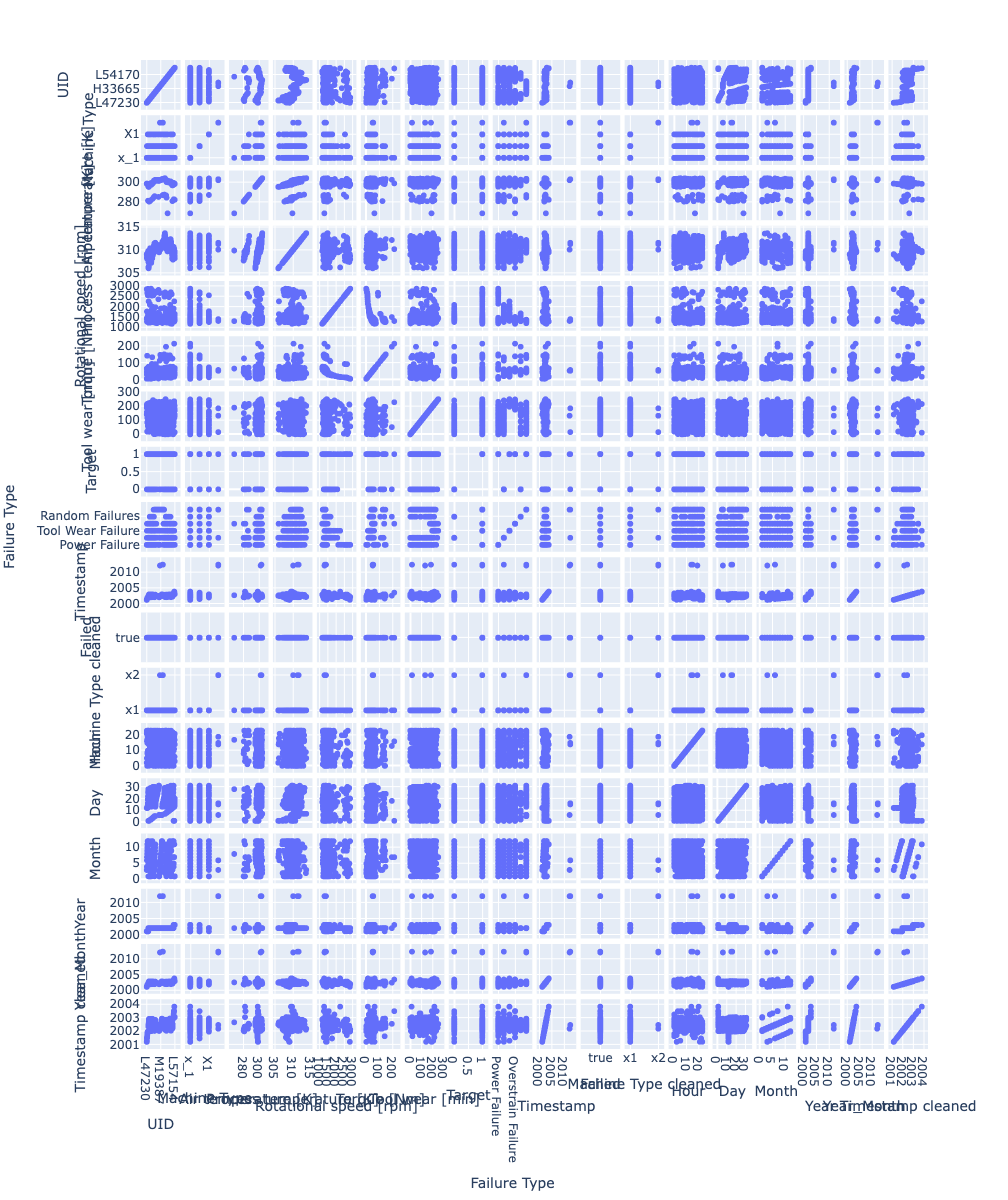

In [292]:
px.scatter_matrix(df[df['Failed']], df.columns, width=1200, height=1200)

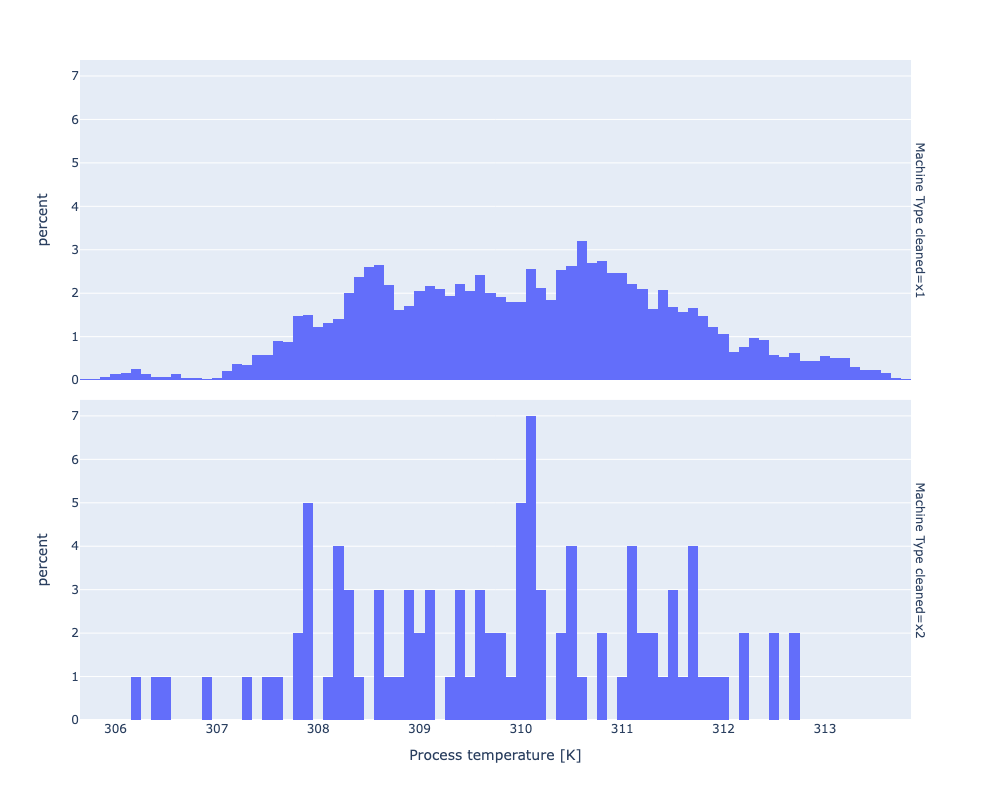

In [89]:
px.histogram(df, x='Process temperature [K]', facet_row='Machine Type cleaned', width=400, height=800, histnorm='percent')

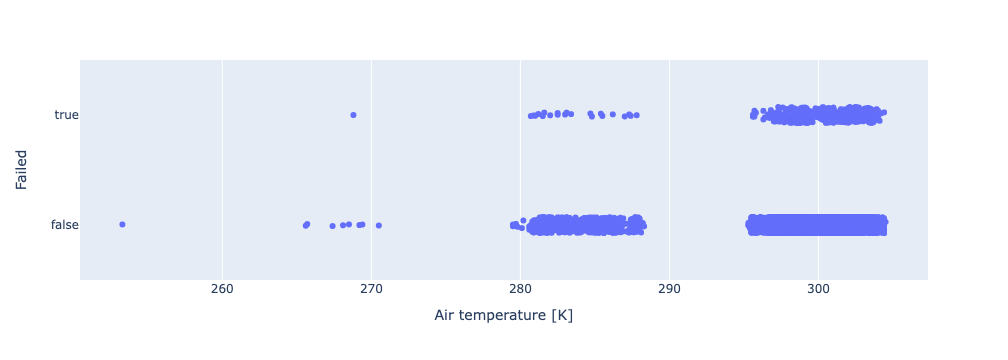

In [190]:
px.strip(df, x='Air temperature [K]', y='Failed')

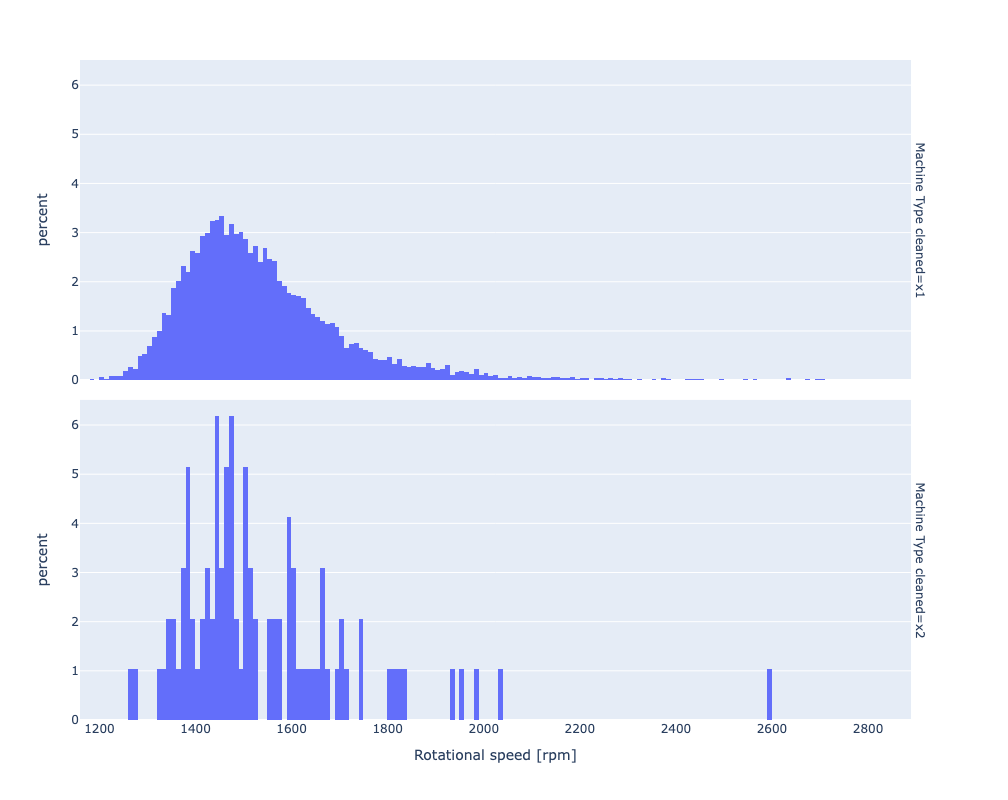

In [99]:
px.histogram(df, x='Rotational speed [rpm]', facet_row='Machine Type cleaned', width=400, height=800, histnorm='percent')

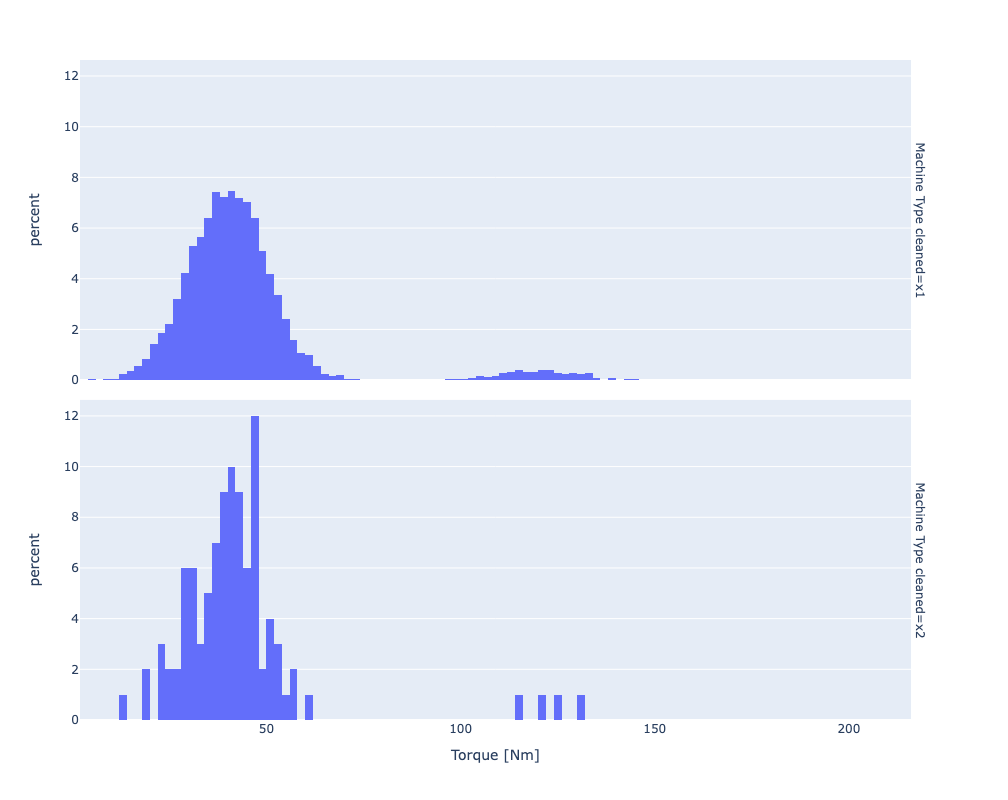

In [100]:
px.histogram(df, x='Torque [Nm]', facet_row='Machine Type cleaned', width=400, height=800, histnorm='percent')

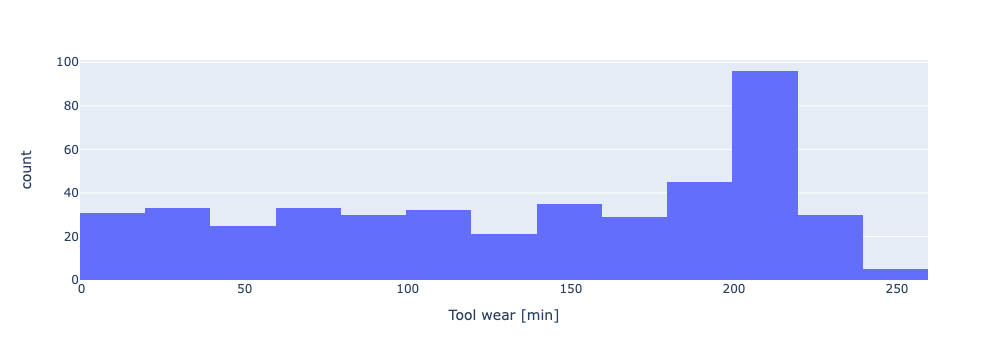

In [285]:
px.histogram(df[df['Failed']], x='Tool wear [min]')

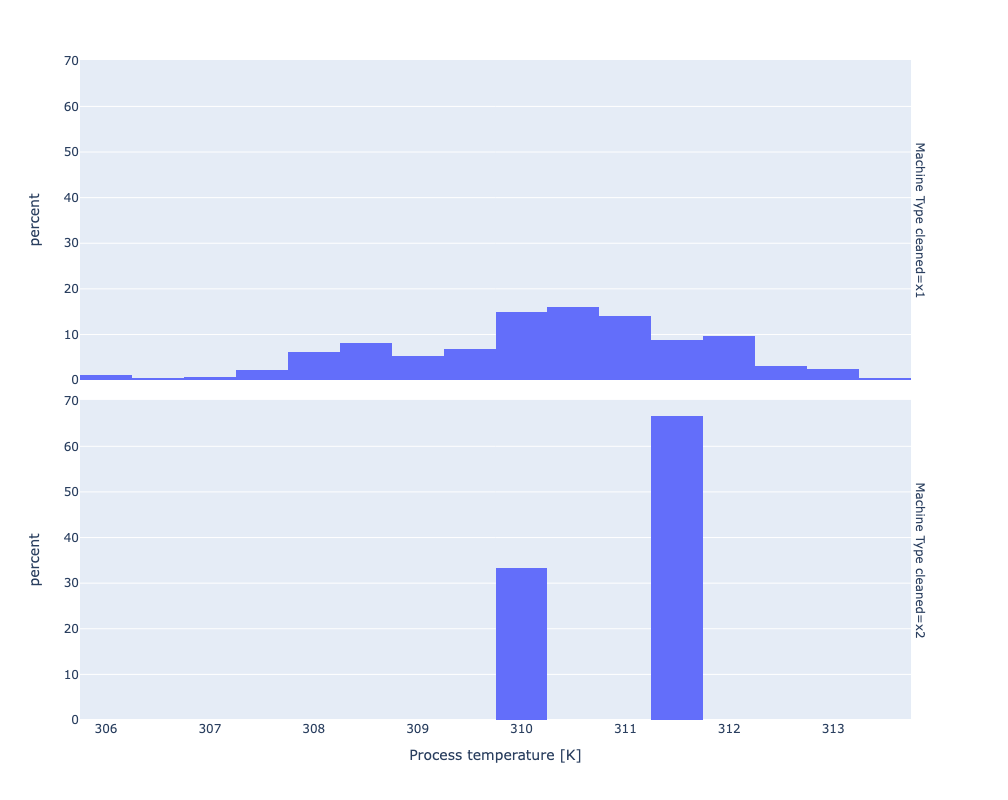

In [200]:
px.histogram(df[df['Failed']], x='Process temperature [K]', facet_row='Machine Type cleaned', width=400, height=800, histnorm='percent')

In [106]:
failures = df[df['Failure Type'] != 'No Failure'].groupby(['Failure Type'])['UID'].count().to_frame()
failures['pc'] = failures['UID'] / failures['UID'].sum()
failures

UID        pc
Failure Type                           
Error                     100  0.223714
Heat Dissipation Failure  112  0.250559
Overstrain Failure         78  0.174497
Power Failure              95  0.212528
Random Failures            17  0.038031
Tool Wear Failure          45  0.100671

In [48]:
df['Failed'] = df['Failure Type'].apply(lambda x: False if x == 'No Failure' else True)

In [325]:
failures = pd.pivot_table(df, index='Machine Type', columns='Failed', values='UID', aggfunc='count')
failures['rate'] = failures[True] / failures.sum(axis=1) * 100
failures

Failed        False  True      rate
Machine Type                       
X1              945    32  3.275333
X2               94     3  3.092784
x1             2831   104  3.543441
x_1            5585   306  5.194364

In [94]:
n_samples = 1000
bootstraps = pd.DataFrame()

for i in tqdm(range(n_samples)):
    samples = df.groupby('Machine Type').sample(n=100, replace=True)
    bootstraps = pd.concat([bootstraps, (samples.groupby('Machine Type')['Failed'].sum() / samples.groupby('Machine Type')['UID'].count()).rename('failure_rate').to_frame().reset_index()])
    
bootstraps.groupby('Machine Type').describe()

  0%|          | 0/1000 [00:00<?, ?it/s]

failure_rate                                                
                    count     mean       std  min   25%   50%   75%   max
Machine Type                                                             
X1                 1000.0  0.03259  0.017558  0.0  0.02  0.03  0.04  0.09
X2                 1000.0  0.02964  0.016594  0.0  0.02  0.03  0.04  0.09
x1                 1000.0  0.03613  0.018891  0.0  0.02  0.03  0.05  0.13
x_1                1000.0  0.05076  0.021778  0.0  0.03  0.05  0.07  0.13

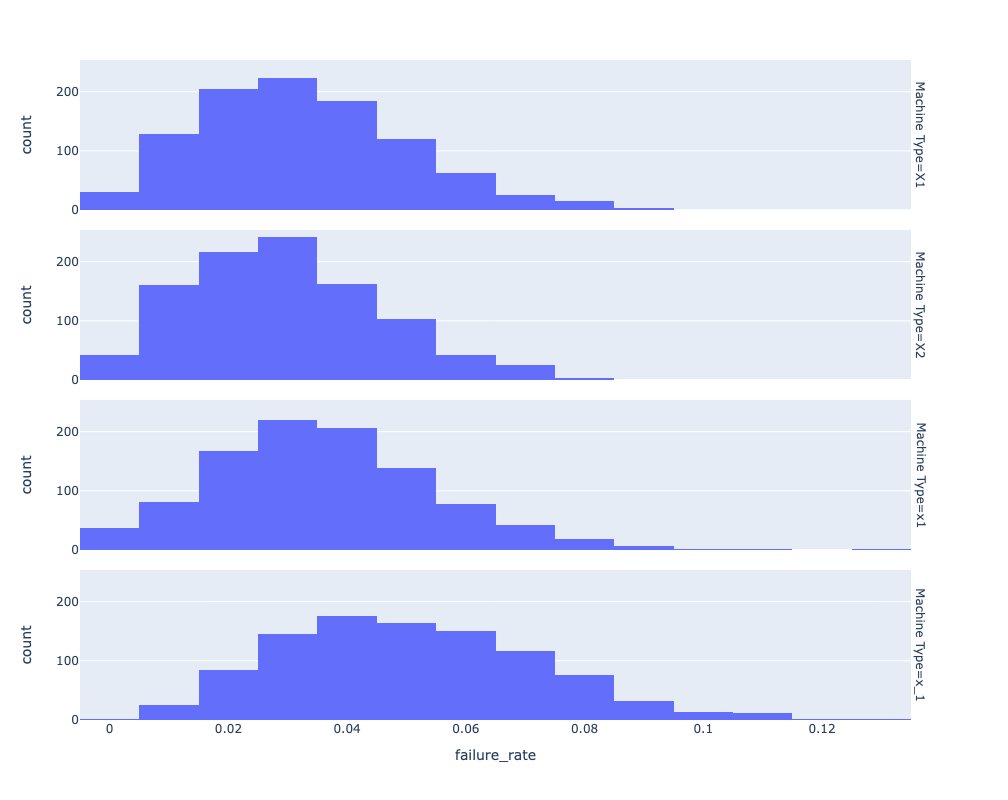

In [95]:
px.histogram(bootstraps, x='failure_rate', facet_row='Machine Type', width=400, height=800)

In [167]:
df.Year.value_counts().sort_index()

2001     731
2002    8683
2003     486
2011      13
2012      77
2013      10
Name: Year, dtype: int64

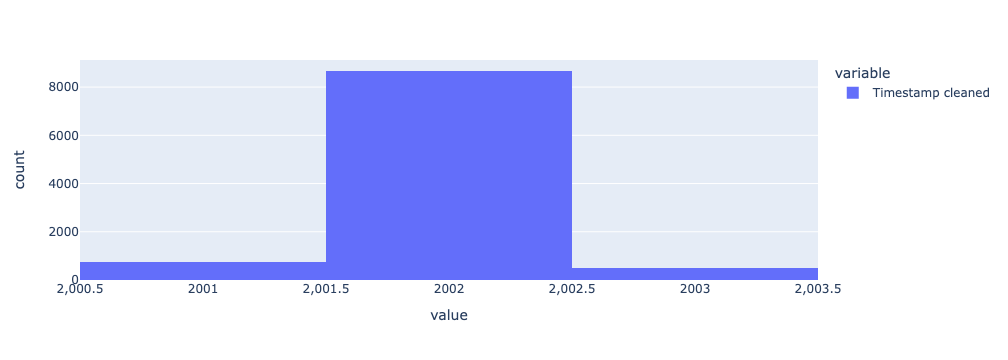

In [293]:
px.histogram(df['Timestamp cleaned'].dt.year)

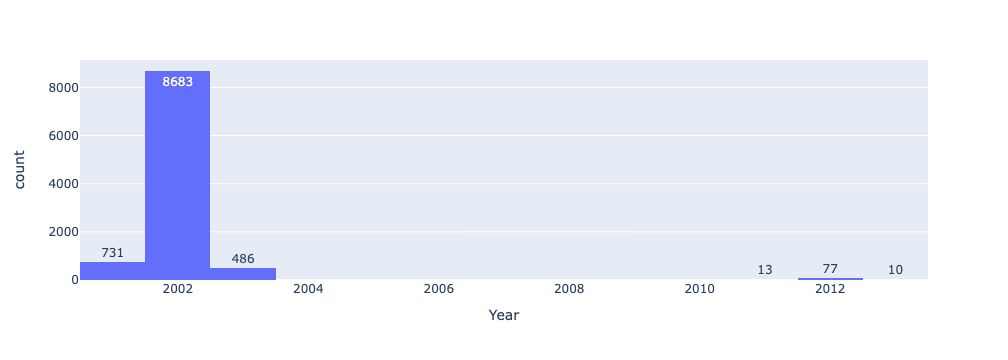

In [171]:
px.histogram(df, x='Year', text_auto=True)


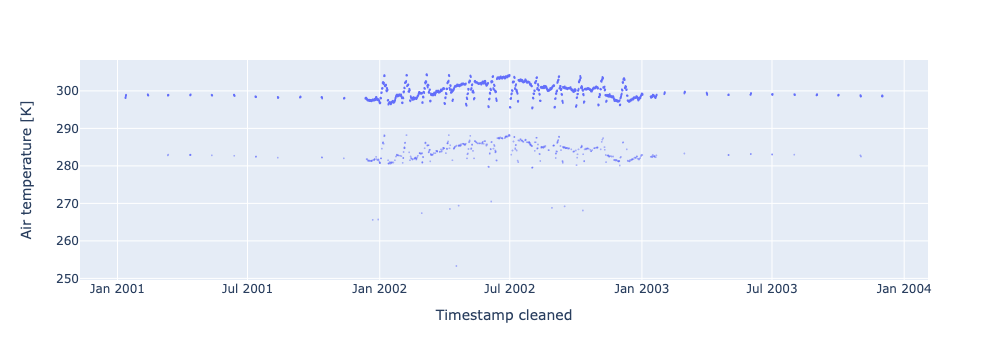

In [294]:
fig = px.scatter(df, x='Timestamp cleaned', y='Air temperature [K]', opacity=0.5)
fig.update_traces(marker=dict(size=2))

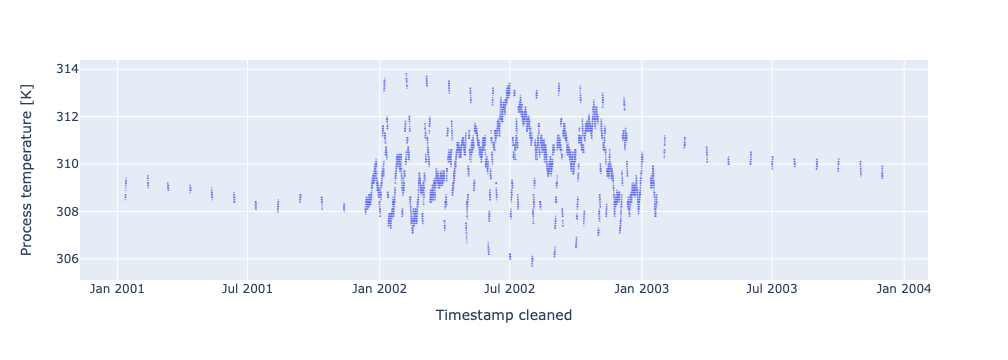

In [322]:
fig = px.scatter(df, x='Timestamp cleaned', y='Process temperature [K]', opacity=0.5)
fig.update_traces(marker=dict(size=2))

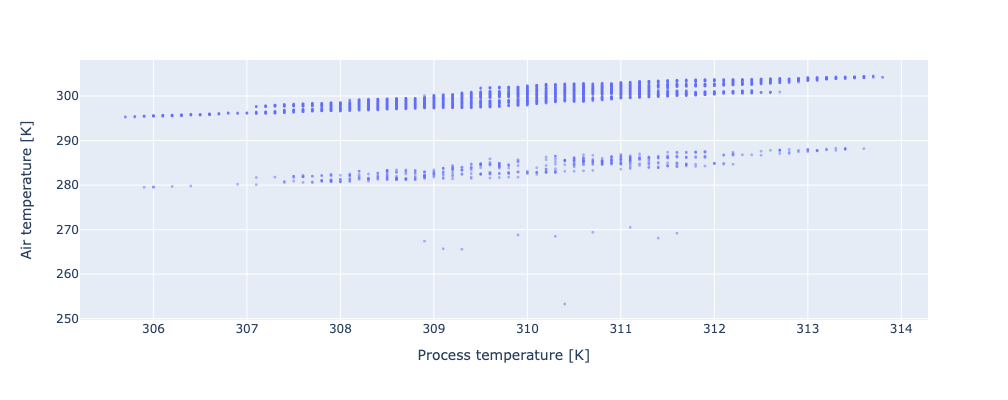

In [323]:
fig = px.scatter(df, x='Process temperature [K]', y='Air temperature [K]', width=400, height=400, opacity=0.5)
fig.update_traces(marker=dict(size=3))

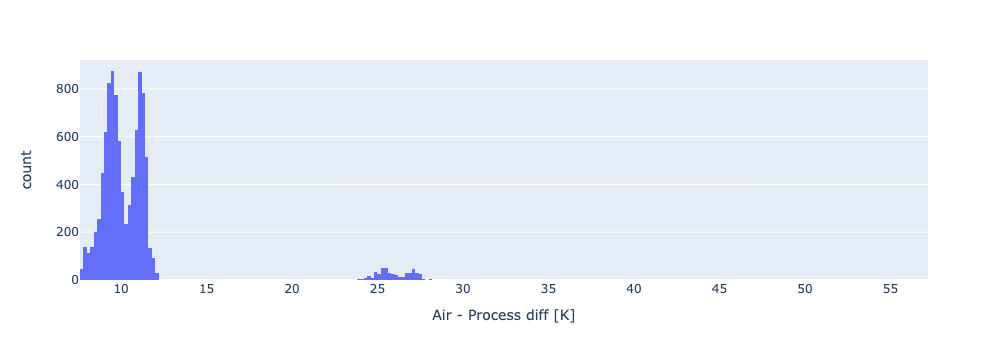

In [299]:
px.histogram(df, x='Air - Process diff [K]')

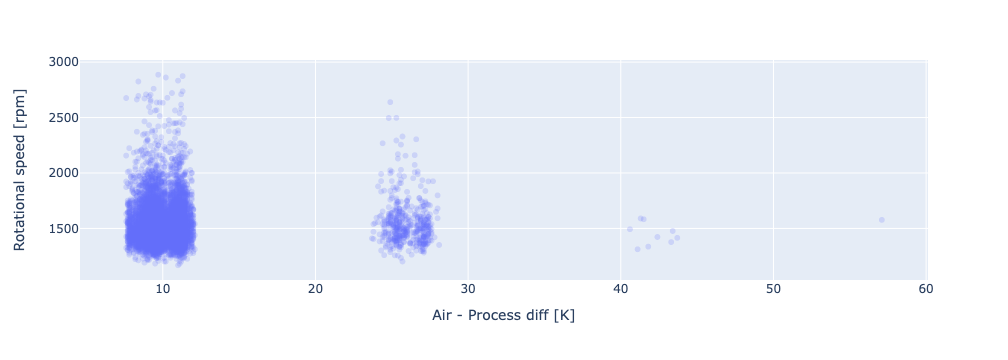

In [324]:
px.scatter(df, x='Air - Process diff [K]', y='Rotational speed [rpm]', opacity=0.2)

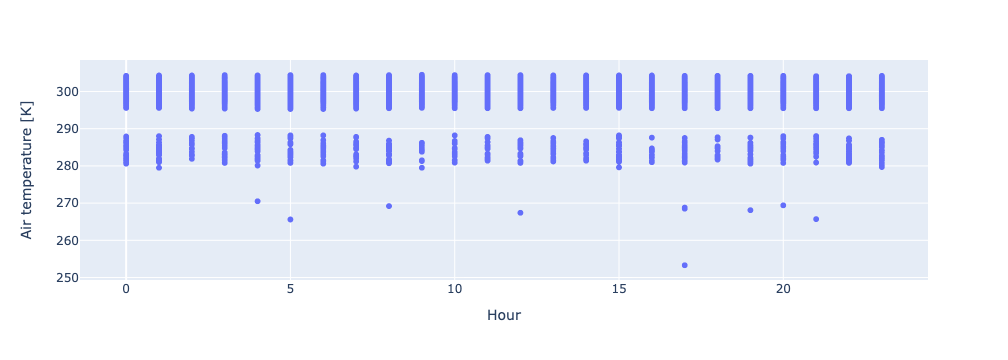

In [147]:
px.scatter(df, x='Hour', y='Air temperature [K]')

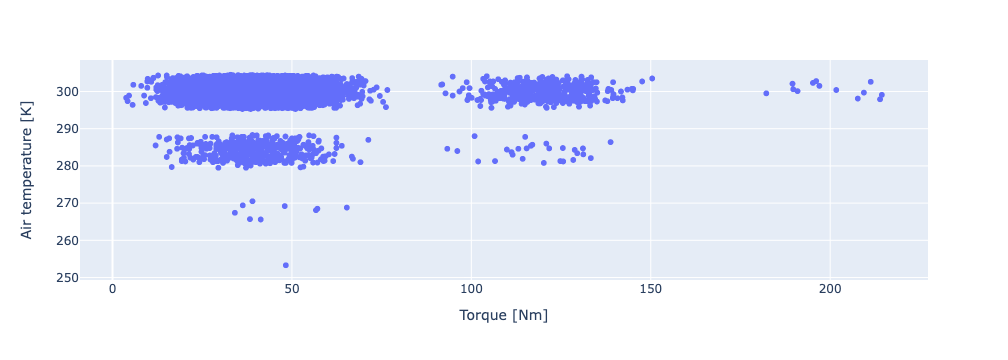

In [151]:
px.scatter(df, x='Torque [Nm]', y='Air temperature [K]')

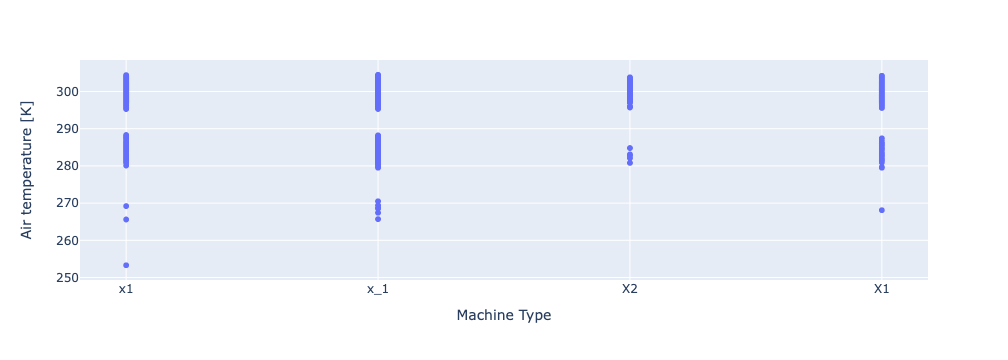

In [178]:
px.scatter(df, x='Machine Type', y='Air temperature [K]')

In [ ]:
pd.pivot_table(df, index='Failure Type', columns='Machine Type', values='UID', aggfunc='count')

Machine Type                 X1    X2      x1     x_1
Failure Type                                         
Error                       8.0   1.0    24.0    67.0
Heat Dissipation Failure    8.0   2.0    30.0    72.0
No Failure                957.0  97.0  2869.0  5630.0
Overstrain Failure          1.0   NaN     4.0    73.0
Power Failure               5.0   NaN    31.0    59.0
Random Failures             4.0   NaN     2.0    11.0
Tool Wear Failure           6.0   NaN    14.0    25.0

In [176]:
pd.pivot_table(df, index='Machine Type', columns='Year', values='UID', aggfunc='count', fill_value=0)

Year          2001  2002  2003  2011  2012  2013
Machine Type                                    
X1              85   844    60     0     0     0
X2               0     0     0    13    77    10
x1             201  2623   150     0     0     0
x_1            445  5216   276     0     0     0

In [203]:
df['Failed'].astype('int').value_counts()

0    9553
1     447
Name: Failed, dtype: int64

In [199]:
pd.get_dummies(df['Machine Type'])

X1  X2  x1  x_1
0      0   0   1    0
1      0   0   0    1
2      0   0   0    1
3      0   0   0    1
4      0   0   0    1
...   ..  ..  ..  ...
9995   0   0   1    0
9996   1   0   0    0
9997   0   0   1    0
9998   1   0   0    0
9999   0   0   1    0

[10000 rows x 4 columns]

In [330]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

#Scale continuous variables and one hot encode categorical variables
scaler = MinMaxScaler()
cols_to_scale = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air - Process diff [K]']
to_scale = df[cols_to_scale]
print(len(to_scale))
scaled = pd.DataFrame(scaler.fit_transform(to_scale))
scaled.columns = [x.lower().replace(' ', '_').replace('[','').replace(']','') for x in cols_to_scale]

dummies = pd.get_dummies(df['Machine Type'])
print(len(dummies))
X = pd.concat([scaled, dummies], axis=1)
y = df['Failed'].astype('int')

print(len(X), len(y))

#Make train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the classes in the training data using SMOTE oversampling
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resampled dataset shape', Counter(y_smote))

9900
9900
9900 9900
Original dataset shape Counter({0: 7559, 1: 361})
Resampled dataset shape Counter({1: 7559, 0: 7559})


In [328]:
x_smote

air_temperature_k  process_temperature_k  rotational_speed_rpm  \
0               0.871094               0.209877              0.253783   
1               0.890625               0.530864              0.122235   
2               0.904297               0.543210              0.224098   
3               0.976562               0.716049              0.125728   
4               0.933594               0.617284              0.241560   
...                  ...                    ...                   ...   
15113           0.922195               0.755331              0.106223   
15114           0.928101               0.543210              0.134978   
15115           0.872250               0.407115              0.212504   
15116           0.952534               0.695664              0.174329   
15117           0.882298               0.477557              0.841505   

       torque_nm  tool_wear_min  air_-_process_diff_k  X1  X2  x1  x_1  
0       0.153371       0.889328              0.038384   1   0   0    0  
1       0.216049       0.071146              0.070707   0   0   0    1  
2       0.162393       0.328063              0.058586   0   0   0    1  
3       0.242165       0.189723              0.012121   0   0   1    0  
4       0.175214       0.007905              0.040404   0   0   1    0  
...          ...            ...                   ...  ..  ..  ..  ...  
15113   0.611646       0.086669              0.074784   0   0   0    1  
15114   0.271770       0.747926              0.033964   0   0   0    1  
15115   0.160042       0.568000              0.069464   0   0   0    1  
15116   0.184995       0.119492              0.033639   0   0   0    1  
15117   0.039630       0.409152              0.070597   0   0   0    1  

[15118 rows x 10 columns]

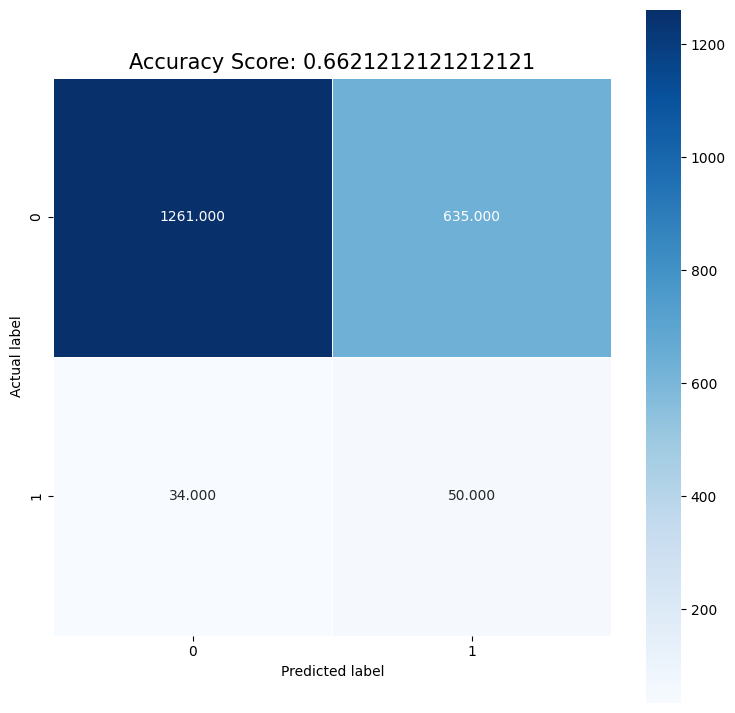

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

logisticRegr = LogisticRegression()
logisticRegr.fit(x_smote, y_smote)
#logisticRegr.fit(X_train, y_train)

pred = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

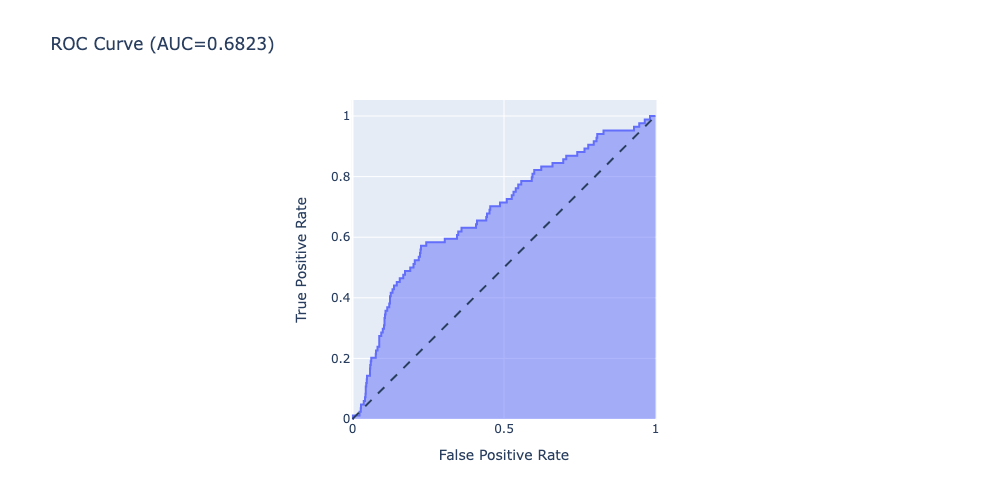

In [306]:
from sklearn.metrics import roc_curve, auc

y_score = logisticRegr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

array([[1859,   37],
       [  37,   47]])

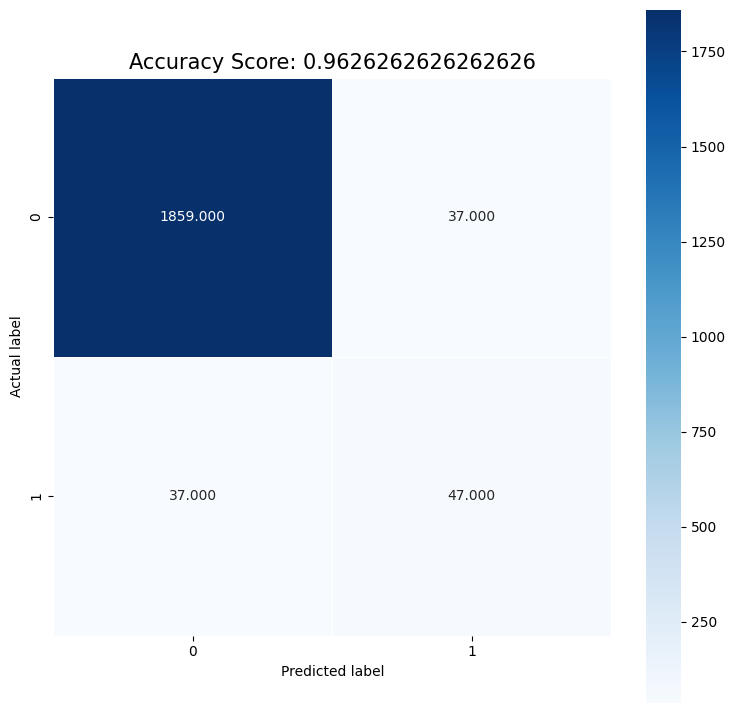

In [326]:
import xgboost as xgb

# fit model to training data
model = xgb.XGBClassifier()
model.fit(x_smote, y_smote)

y_pred = model.predict(X_test)
pred = model.predict(X_test)
score = model.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
cm

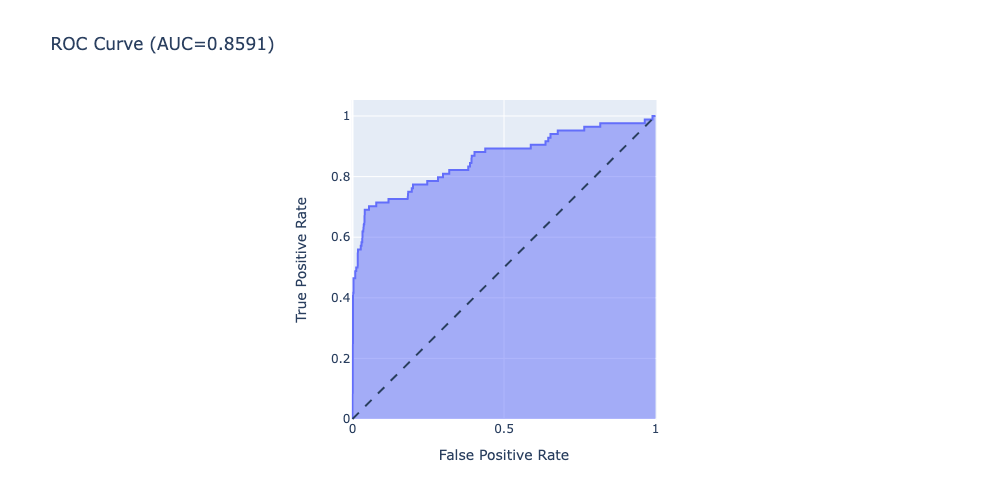

In [331]:
y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [317]:
importance = pd.DataFrame({'feature':X_train.columns, 'importance':model.feature_importances_}).sort_values(by='importance', ascending=False)
importance

feature  importance
2   rotational_speed_rpm    0.276317
5   air_-_process_diff_k    0.141337
4          tool_wear_min    0.128787
3              torque_nm    0.082101
1  process_temperature_k    0.073343
6                     X1    0.067495
0      air_temperature_k    0.065680
8                     x1    0.062702
9                    x_1    0.061783
7                     X2    0.040456

In [310]:
import shap

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
explainer_xgb = shap.Explainer(model, X100)
shap_values_xgb = explainer_xgb(X)

 94%|=================== | 9314/9900 [00:14<00:00]       

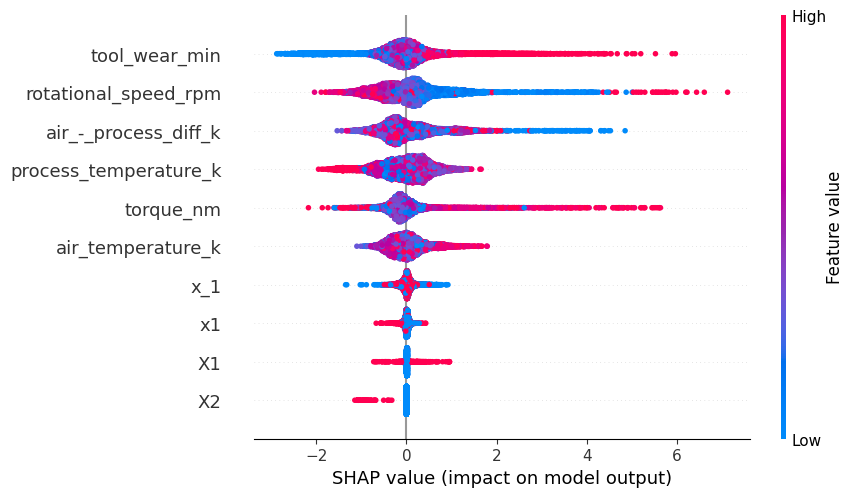

In [311]:
shap.plots.beeswarm(shap_values_xgb)

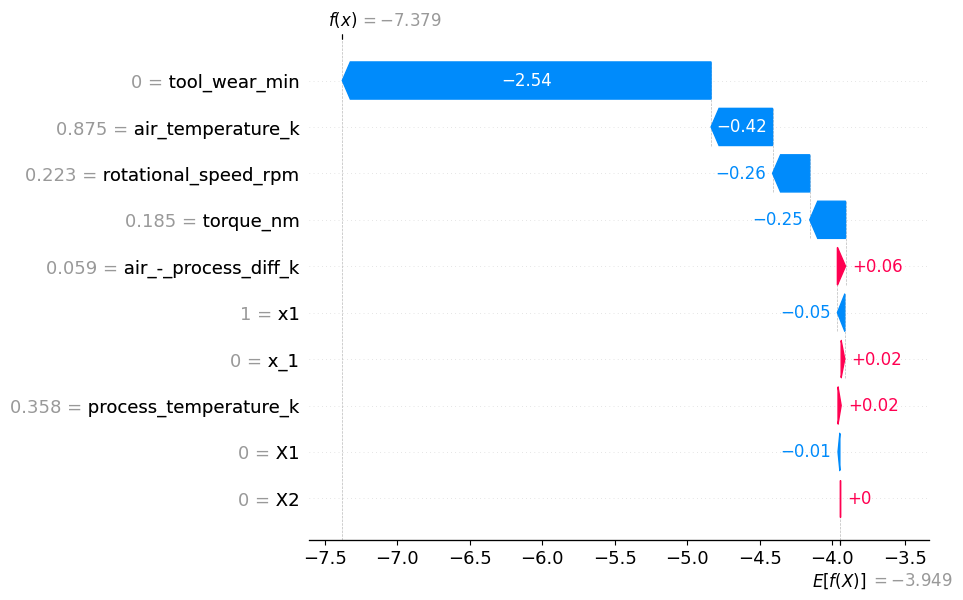

In [321]:
shap.plots.waterfall(shap_values_xgb[0])